RMSE: 2291.2126531907616


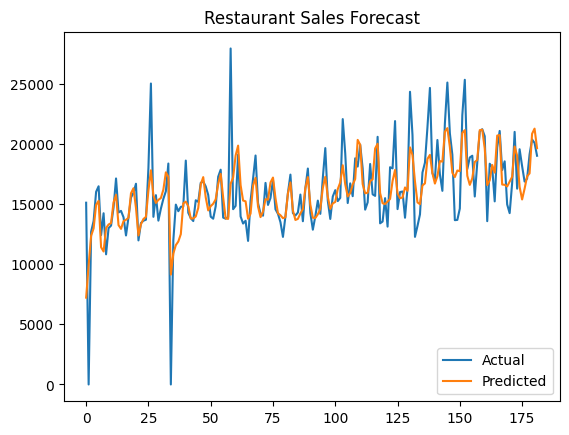

In [31]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Simulated dataset
dates = pd.date_range(start="2024-01-01", periods=100)

df = pd.read_csv("data/rest_sales.csv")

# Feature engineering
df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y")

# Define sales as inside_sales for this model
df["sales"] = df["inside_sales"] + df["outside_sales"]

# Feature engineering
df["day_of_week"] = df["date"].dt.dayofweek
df["month"] = df["date"].dt.month
df["lag_1"] = df["sales"].shift(1).bfill()
df["rolling_7"] = df["sales"].rolling(7).mean().bfill()

# Define features and target
X = df[["day_of_week", "month", "lag_1", "rolling_7"]]
y = df["sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# Fast model setup
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Prediction
y_pred = model.predict(X_test)

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

# Plot
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Restaurant Sales Forecast")
plt.show()

RMSE: 610.1858012733883
Percentage RMSE/Mean:  77.15171269234426 %


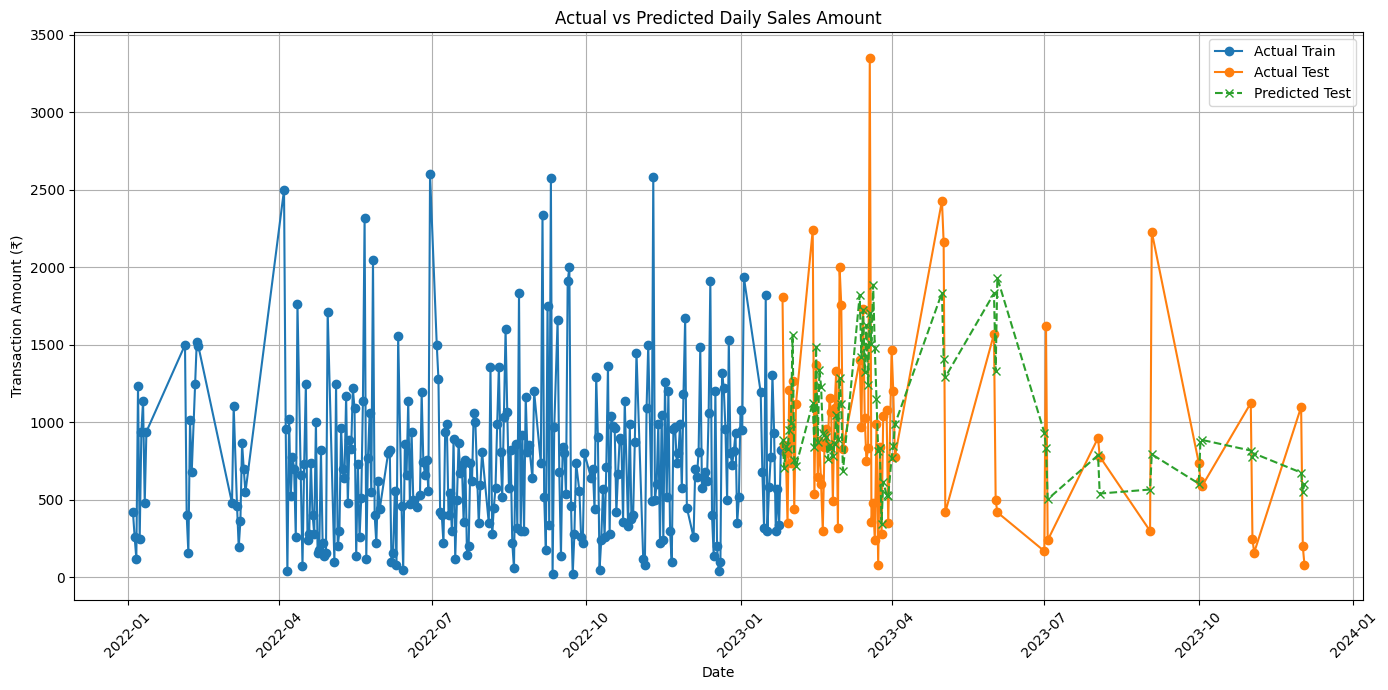

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Load data
df = pd.read_csv("data/test/balaji_sales.csv")

# Parse dates
df["Date"] = pd.to_datetime(df["date"], format='mixed', dayfirst=True)

# Sort by Date
df.sort_values(by="Date", inplace=True)

# Group by Date and sum
daily_sales = df.groupby("Date")[["quantity", "transaction_amount"]].sum().reset_index()

# Feature Engineering (on grouped daily_sales)
daily_sales["day_of_week"] = daily_sales["Date"].dt.dayofweek
daily_sales["month"] = daily_sales["Date"].dt.month
daily_sales["lag_1"] = daily_sales["transaction_amount"].shift(1).bfill()
daily_sales["rolling_7"] = daily_sales["transaction_amount"].rolling(7).mean().bfill()

# Define features and target
X = daily_sales[["day_of_week", "month", "lag_1", "rolling_7"]]
y = daily_sales["transaction_amount"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
dates_train = daily_sales["Date"][:len(X_train)]
dates_test = daily_sales["Date"][len(X_train):]

# Model
model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("Percentage RMSE/Mean: (Normalized Error)", rmse/daily_sales["transaction_amount"].mean() * 100, '%')
# Plot
plt.figure(figsize=(14, 7))

# Plot actual sales (whole timeline)
plt.plot(dates_train, y_train, label="Actual Train", marker='o')
plt.plot(dates_test, y_test, label="Actual Test", marker='o')

# Plot predicted sales (only for test set)
plt.plot(dates_test, y_pred, label="Predicted Test", marker='x', linestyle="--")

plt.title("Actual vs Predicted Daily Sales Amount")
plt.xlabel("Date")
plt.ylabel("Transaction Amount (₹)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 278, number of used features: 7
[LightGBM] [Info] Start training from score 751.140501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

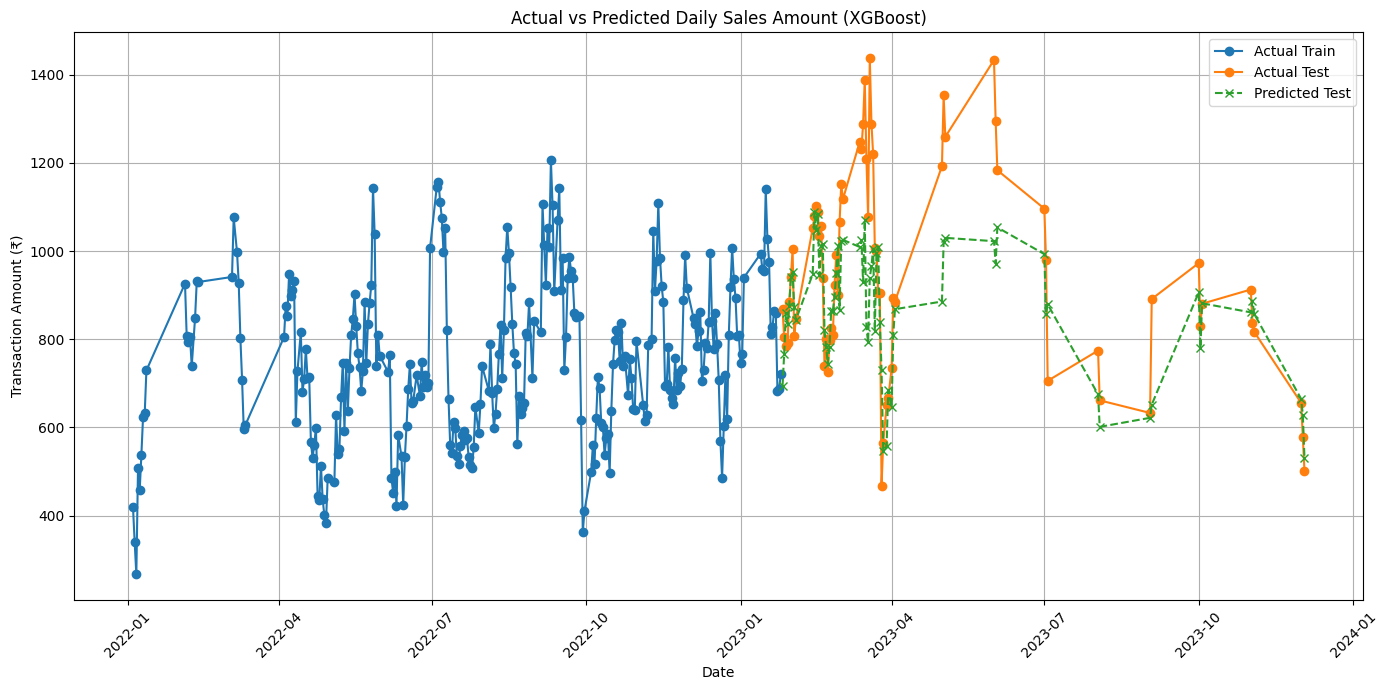

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb 

# Load data
df = pd.read_csv("data/test/balaji_sales.csv")

# Parse dates
df["Date"] = pd.to_datetime(df["date"], format='mixed', dayfirst=True)

# Sort by Date
df.sort_values(by="Date", inplace=True)

# Group by Date and sum
daily_sales = df.groupby("Date")[["quantity", "transaction_amount"]].sum().reset_index()

# Feature Engineering (on grouped daily_sales)
daily_sales["day_of_week"] = daily_sales["Date"].dt.dayofweek
daily_sales["month"] = daily_sales["Date"].dt.month
daily_sales["is_weekend"] = daily_sales["day_of_week"].isin([5,6]).astype(int)  # Saturday/Sunday

daily_sales["lag_1"] = daily_sales["transaction_amount"].shift(1).bfill()
daily_sales["rolling_7"] = daily_sales["transaction_amount"].shift(1).rolling(7).mean().bfill()
daily_sales["lag_7"] = daily_sales["transaction_amount"].shift(7).bfill()
daily_sales["rolling_14"] = daily_sales["transaction_amount"].shift(1).rolling(14).mean().bfill()

daily_sales["transaction_amount_smooth"] = daily_sales["transaction_amount"].rolling(window=7, min_periods=1).mean()

# Define features and target
X = daily_sales[["day_of_week", "month", "is_weekend", "lag_7", "rolling_14", "lag_1", "rolling_7"]]
y = daily_sales["transaction_amount_smooth"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
dates_train = daily_sales["Date"][:len(X_train)]
dates_test = daily_sales["Date"][len(X_train):]

# ----------------
# LightGBM Model
# ----------------
model = lgb.LGBMRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("Percentage RMSE/Mean (Normalized Error):", rmse/daily_sales["transaction_amount"].mean() * 100, '%')

mae = mean_absolute_error(y_test, y_pred)
print("MAE (Mean Absolute Error):", mae)
print("Percentage MAE/Mean (Normalized Error):", mae/daily_sales["transaction_amount"].mean() * 100, '%')

medae = median_absolute_error(y_test, y_pred)
print("MedAE (Median Absolute Error):", medae)
print("Percentage MedAE/Mean (Normalized Error):", medae/daily_sales["transaction_amount"].mean() * 100, '%')

# Plot
plt.figure(figsize=(14, 7))

# Plot actual sales (whole timeline)
plt.plot(dates_train, y_train, label="Actual Train", marker='o')
plt.plot(dates_test, y_test, label="Actual Test", marker='o')

# Plot predicted sales (only for test set)
plt.plot(dates_test, y_pred, label="Predicted Test", marker='x', linestyle="--")

plt.title("Actual vs Predicted Daily Sales Amount (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Transaction Amount (₹)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 278, number of used features: 7
[LightGBM] [Info] Start training from score 751.140501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/Users/apple/Desktop/Programming/RestaurantForecast/.venv-py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/apple/Desktop/Programming/RestaurantForecast/.venv-py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/apple/Desktop/Programming/RestaurantForecast/.venv-py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/apple/Desktop/Programming/RestaurantForecast/.venv-py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/apple/Desktop/Programming

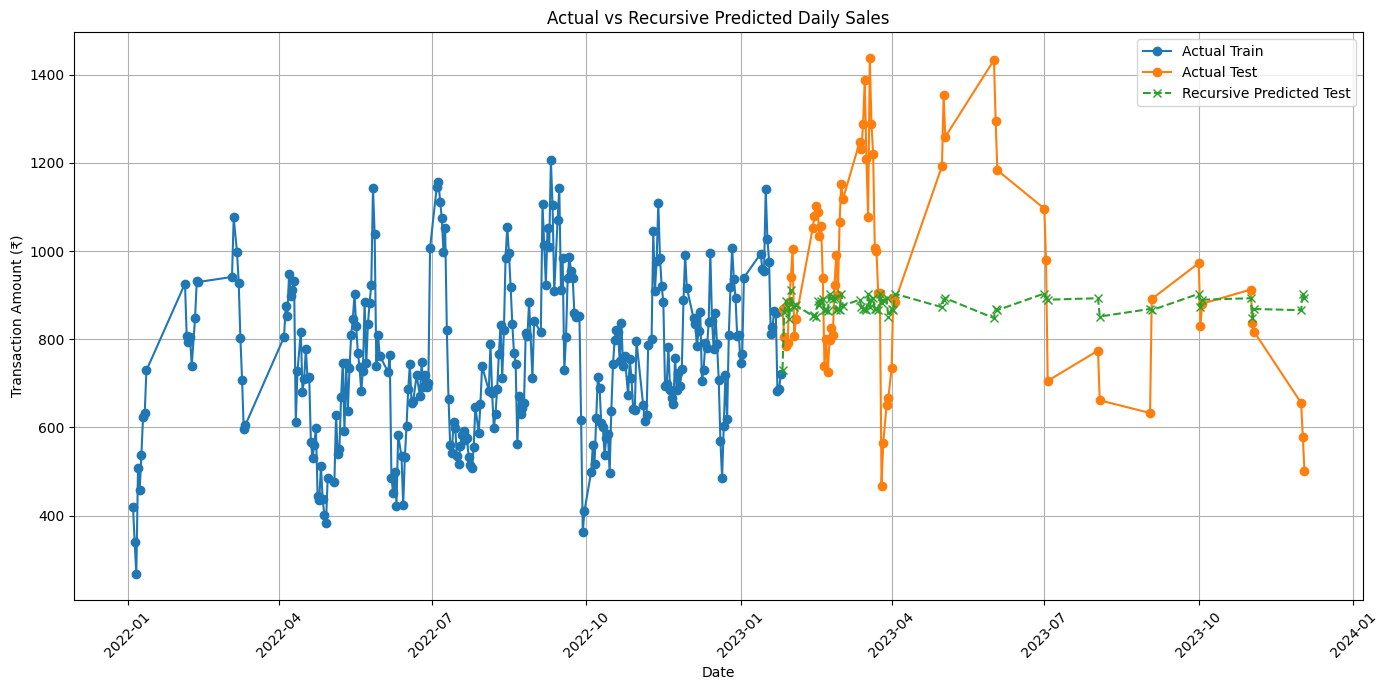

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error

from xgboost import XGBRegressor  

# Load data
df = pd.read_csv("data/test/balaji_sales.csv")

# Parse dates
df["Date"] = pd.to_datetime(df["date"], format='mixed', dayfirst=True)

# Sort by Date
df.sort_values(by="Date", inplace=True)

# Group by Date and sum
daily_sales = df.groupby("Date")[["quantity", "transaction_amount"]].sum().reset_index()

# Feature Engineering (on grouped daily_sales)
daily_sales["day_of_week"] = daily_sales["Date"].dt.dayofweek
daily_sales["month"] = daily_sales["Date"].dt.month
daily_sales["is_weekend"] = daily_sales["day_of_week"].isin([5,6]).astype(int)  # Saturday/Sunday

daily_sales["lag_1"] = daily_sales["transaction_amount"].shift(1).bfill()
daily_sales["rolling_7"] = daily_sales["transaction_amount"].shift(1).rolling(7).mean().bfill()
daily_sales["lag_7"] = daily_sales["transaction_amount"].shift(7).bfill()
daily_sales["rolling_14"] = daily_sales["transaction_amount"].shift(1).rolling(14).mean().bfill()

daily_sales["transaction_amount_smooth"] = daily_sales["transaction_amount"].rolling(window=7, min_periods=1).mean()

# Define features and target
X = daily_sales[["day_of_week", "month", "is_weekend", "lag_7", "rolling_14", "lag_1", "rolling_7"]]
y = daily_sales["transaction_amount_smooth"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
dates_train = daily_sales["Date"][:len(X_train)]
dates_test = daily_sales["Date"][len(X_train):]

model = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    objective="reg:squarederror",  # Very important for regression!
    random_state=42
)

model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("Percentage RMSE/Mean (Normalized Error):", rmse/daily_sales["transaction_amount"].mean() * 100, '%')

mae = mean_absolute_error(y_test, y_pred)
print("MAE (Mean Absolute Error):", mae)
print("Percentage MAE/Mean (Normalized Error):", mae/daily_sales["transaction_amount"].mean() * 100, '%')

medae = median_absolute_error(y_test, y_pred)
print("MedAE (Median Absolute Error):", medae)
print("Percentage MedAE/Mean (Normalized Error):", medae/daily_sales["transaction_amount"].mean() * 100, '%')

# Plot
plt.figure(figsize=(14, 7))

# Plot actual sales (whole timeline)
plt.plot(dates_train, y_train, label="Actual Train", marker='o')
plt.plot(dates_test, y_test, label="Actual Test", marker='o')

# Plot predicted sales (only for test set)
plt.plot(dates_test, y_pred, label="Predicted Test", marker='x', linestyle="--")

plt.title("Actual vs Predicted Daily Sales Amount (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Transaction Amount (₹)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 342
[LightGBM] [Info] Number of data points in the train set: 278, number of used features: 7
[LightGBM] [Info] Start training from score 751.140501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

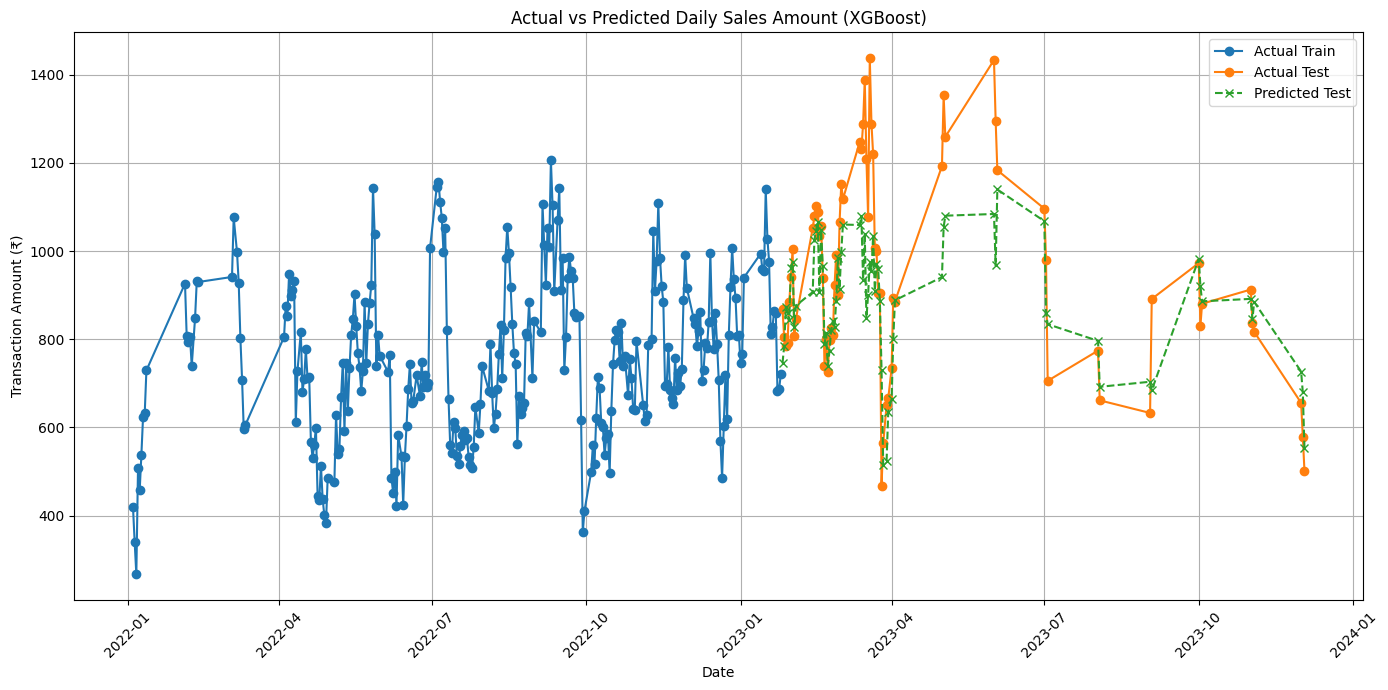

In [3]:
# COMBINING XGB AND LGM

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error

from xgboost import XGBRegressor  
import lightgbm as lgb

# Load data
df = pd.read_csv("data/test/balaji_sales.csv")

# Parse dates
df["Date"] = pd.to_datetime(df["date"], format='mixed', dayfirst=True)

# Sort by Date
df.sort_values(by="Date", inplace=True)

# Group by Date and sum
daily_sales = df.groupby("Date")[["quantity", "transaction_amount"]].sum().reset_index()

# Feature Engineering (on grouped daily_sales)
daily_sales["day_of_week"] = daily_sales["Date"].dt.dayofweek
daily_sales["month"] = daily_sales["Date"].dt.month
daily_sales["is_weekend"] = daily_sales["day_of_week"].isin([5,6]).astype(int)  # Saturday/Sunday

daily_sales["lag_1"] = daily_sales["transaction_amount"].shift(1)
daily_sales["rolling_7"] = daily_sales["transaction_amount"].shift(1).rolling(7).mean()
daily_sales["lag_7"] = daily_sales["transaction_amount"].shift(7)
daily_sales["rolling_14"] = daily_sales["transaction_amount"].shift(1).rolling(14).mean()

daily_sales["transaction_amount_smooth"] = daily_sales["transaction_amount"].rolling(window=7, min_periods=1).mean()
# 
# Define features and target
X = daily_sales[["day_of_week", "month", "is_weekend", "lag_7", "rolling_14", "lag_1", "rolling_7"]]
y = daily_sales["transaction_amount_smooth"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
dates_train = daily_sales["Date"][:len(X_train)]
dates_test = daily_sales["Date"][len(X_train):]

model = XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    objective="reg:squarederror",  # Very important for regression!
    random_state=42
)

model.fit(X_train, y_train)

xgb_pred = model.predict(X_test)

lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.05,
    random_state=42
)
lgb_model.fit(X_train, y_train)

# Predict
lgb_pred = model.predict(X_test)

y_pred = (lgb_pred + xgb_pred) / 2

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)
print("Percentage RMSE/Mean (Normalized Error):", rmse/daily_sales["transaction_amount"].mean() * 100, '%')

mae = mean_absolute_error(y_test, y_pred)
print("MAE (Mean Absolute Error):", mae)
print("Percentage MAE/Mean (Normalized Error):", mae/daily_sales["transaction_amount"].mean() * 100, '%')

medae = median_absolute_error(y_test, y_pred)
print("MedAE (Median Absolute Error):", medae)
print("Percentage MedAE/Mean (Normalized Error):", medae/daily_sales["transaction_amount"].mean() * 100, '%')

# Plot
plt.figure(figsize=(14, 7))

# Plot actual sales (whole timeline)
plt.plot(dates_train, y_train, label="Actual Train", marker='o')
plt.plot(dates_test, y_test, label="Actual Test", marker='o')

# Plot predicted sales (only for test set)
plt.plot(dates_test, y_pred, label="Predicted Test", marker='x', linestyle="--")

plt.title("Actual vs Predicted Daily Sales Amount (XGBoost)")
plt.xlabel("Date")
plt.ylabel("Transaction Amount (₹)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 267, number of used features: 7
[LightGBM] [Info] Start training from score 761.853933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/Users/apple/Desktop/Programming/RestaurantForecast/.venv-py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/apple/Desktop/Programming/RestaurantForecast/.venv-py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/apple/Desktop/Programming/RestaurantForecast/.venv-py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/apple/Desktop/Programming/RestaurantForecast/.venv-py311/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/apple/Desktop/Programming

RMSE: 711.281347018745
Percentage RMSE/Mean (Normalized Error): 89.41547288353375 %
MAE (Mean Absolute Error): 547.1142042336888
Percentage MAE/Mean (Normalized Error): 68.7779533343566 %
MedAE (Median Absolute Error): 464.72155763193905
Percentage MedAE/Mean (Normalized Error): 58.42033958713826 %


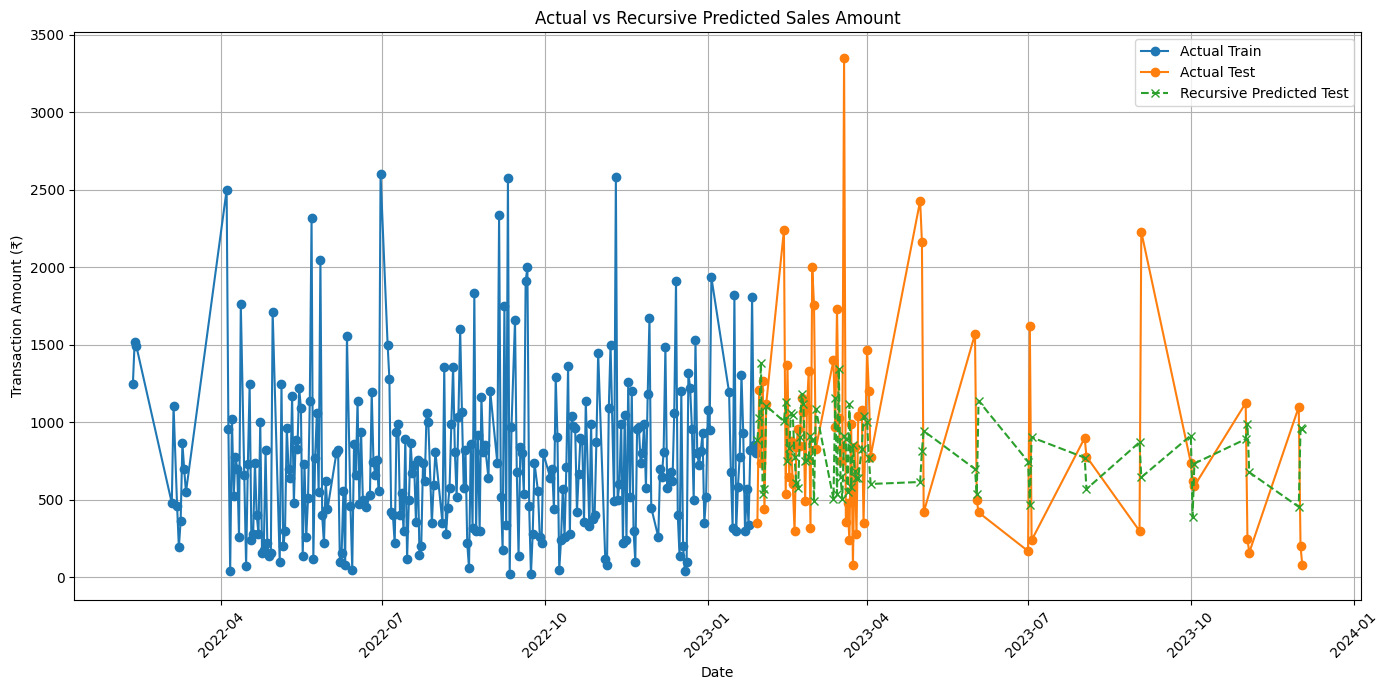

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from xgboost import XGBRegressor
import lightgbm as lgb

# Load data
df = pd.read_csv("data/test/balaji_sales.csv")

# Parse dates
df["Date"] = pd.to_datetime(df["date"], format='mixed', dayfirst=True)

# Sort by Date
df.sort_values(by="Date", inplace=True)

# Group by Date and sum
daily_sales = df.groupby("Date")[["quantity", "transaction_amount"]].sum().reset_index()

# Feature Engineering
daily_sales["day_of_week"] = daily_sales["Date"].dt.dayofweek
daily_sales["month"] = daily_sales["Date"].dt.month
daily_sales["is_weekend"] = daily_sales["day_of_week"].isin([5,6]).astype(int)

daily_sales["lag_1"] = daily_sales["transaction_amount"].shift(1)
daily_sales["rolling_7"] = daily_sales["transaction_amount"].shift(1).rolling(7).mean()
daily_sales["lag_7"] = daily_sales["transaction_amount"].shift(7)
daily_sales["rolling_14"] = daily_sales["transaction_amount"].shift(1).rolling(14).mean()

daily_sales["transaction_amount_smooth"] = daily_sales["transaction_amount"].rolling(window=7, min_periods=1).mean()

# Drop initial rows with NaN
daily_sales = daily_sales.dropna().reset_index(drop=True)

# Define features and target
X = daily_sales[["day_of_week", "month", "is_weekend", "lag_7", "rolling_14", "lag_1", "rolling_7"]]
y = daily_sales["transaction_amount"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
dates_train = daily_sales["Date"][:len(X_train)]
dates_test = daily_sales["Date"][len(X_train):]

# Train models
xgb_model = XGBRegressor(n_estimators=500, max_depth=5, learning_rate=0.05, objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train, y_train)

lgb_model = lgb.LGBMRegressor(n_estimators=500, max_depth=5, learning_rate=0.05, random_state=42)
lgb_model.fit(X_train, y_train)

# ----------- Recursive Prediction (Fixed) -----------

# Start with the last row of X_train
last_known_row = X_train.iloc[-1].copy()

# Save rolling values separately
rolling_values = list(daily_sales["transaction_amount"].iloc[len(X_train)-14:len(X_train)])

recursive_preds = []

for i in range(len(X_test)):
    # Prepare input row (only the 7 features)
    input_row = last_known_row[["day_of_week", "month", "is_weekend", "lag_7", "rolling_14", "lag_1", "rolling_7"]]

    # Predict with both models
    xgb_pred = xgb_model.predict(input_row.values.reshape(1, -1))[0]
    lgb_pred = lgb_model.predict(input_row.values.reshape(1, -1))[0]

    # Average prediction
    final_pred = (xgb_pred + lgb_pred) / 2
    recursive_preds.append(final_pred)

    # Update lag and rolling features for next prediction
    rolling_values.append(final_pred)
    if len(rolling_values) > 14:
        rolling_values = rolling_values[-14:]

    last_known_row["lag_7"] = rolling_values[-7] if len(rolling_values) >= 7 else final_pred
    last_known_row["lag_1"] = final_pred
    last_known_row["rolling_7"] = np.mean(rolling_values[-7:])
    last_known_row["rolling_14"] = np.mean(rolling_values)

    # Update date-based features for the next day
    next_date = dates_test.iloc[i]
    last_known_row["day_of_week"] = next_date.dayofweek
    last_known_row["month"] = next_date.month
    last_known_row["is_weekend"] = 1 if next_date.dayofweek in [5,6] else 0

# Evaluate
recursive_preds = np.array(recursive_preds)

rmse = np.sqrt(mean_squared_error(y_test, recursive_preds))
mae = mean_absolute_error(y_test, recursive_preds)
medae = median_absolute_error(y_test, recursive_preds)

print("RMSE:", rmse)
print("Percentage RMSE/Mean (Normalized Error):", rmse / daily_sales["transaction_amount"].mean() * 100, '%')
print("MAE (Mean Absolute Error):", mae)
print("Percentage MAE/Mean (Normalized Error):", mae / daily_sales["transaction_amount"].mean() * 100, '%')
print("MedAE (Median Absolute Error):", medae)
print("Percentage MedAE/Mean (Normalized Error):", medae / daily_sales["transaction_amount"].mean() * 100, '%')

# Plot
plt.figure(figsize=(14, 7))
plt.plot(dates_train, y_train, label="Actual Train", marker='o')
plt.plot(dates_test, y_test, label="Actual Test", marker='o')
plt.plot(dates_test, recursive_preds, label="Recursive Predicted Test", marker='x', linestyle="--")

plt.title("Actual vs Recursive Predicted Sales Amount")
plt.xlabel("Date")
plt.ylabel("Transaction Amount (₹)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# The model is incapable of predicting daily sales with good accuracy, after analyzing the graph, it seems to be that 
# the target is too noisy and unpredictable with the given features
# However, the model seems to capture trends well, hence changing the target to be weekly sales rather than daily is a notable approach

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from xgboost import XGBRegressor
import lightgbm as lgb

# Load data
df = pd.read_csv("data/test/balaji_sales.csv")


df["Date"] = pd.to_datetime(df["date"], format='mixed', dayfirst=True)
df.sort_values(by="Date", inplace=True)
daily_sales = df.groupby("Date")[["quantity", "transaction_amount"]].sum().reset_index()
daily_sales["month"] = daily_sales["Date"].dt.month

daily_sales["week"] = 0 # initialize the week to be 0

daily_sales["week"] = (np.arange(len(daily_sales)) // 7) + 1

print(daily_sales[["Date", "week"]].head(14))
print(daily_sales[["Date", "week"]].tail())

         Date  week
0  2022-01-04     1
1  2022-01-05     1
2  2022-01-06     1
3  2022-01-07     1
4  2022-01-08     1
5  2022-01-09     1
6  2022-01-10     1
7  2022-01-11     2
8  2022-01-12     2
9  2022-02-04     2
10 2022-02-05     2
11 2022-02-06     2
12 2022-02-07     2
13 2022-02-08     2
          Date  week
343 2023-11-02    50
344 2023-11-03    50
345 2023-12-01    50
346 2023-12-02    50
347 2023-12-03    50


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 36, number of used features: 0
[LightGBM] [Info] Start training from score 5281.805556
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the s

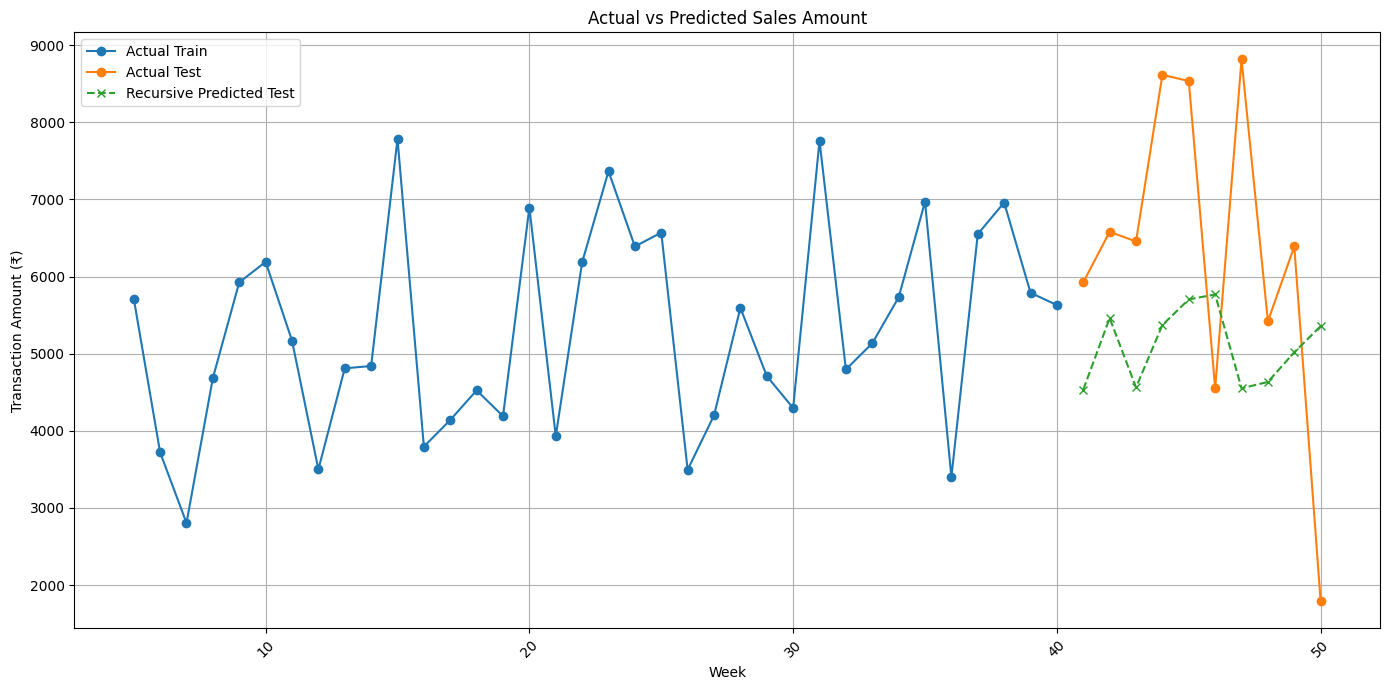

In [ ]:

# Group by Date and sum
weekly_sales = daily_sales.groupby("week")[["quantity", "transaction_amount"]].sum().reset_index()

weekly_sales["lag_1"] = weekly_sales["transaction_amount"].shift(1)  # Previous week
weekly_sales["rolling_2"] = weekly_sales["transaction_amount"].shift(1).rolling(2).mean()  # Average of the last two weeks
weekly_sales["lag_4"] = weekly_sales["transaction_amount"].shift(4)  # Previous month
weekly_sales["rolling_4"] = weekly_sales["transaction_amount"].shift(1).rolling(4).mean()  # Average of the last month

weekly_sales["trend"] = weekly_sales["transaction_amount"] > weekly_sales["lag_1"]  # boolean (if true, the trend is going up)

# Drop initial rows with NaN
weekly_sales = weekly_sales.dropna().reset_index(drop=True)

# Define features and target
X = weekly_sales[["lag_1", "rolling_2", "lag_4", "rolling_4"]]
y = weekly_sales["transaction_amount"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
dates_train = weekly_sales["week"][:len(X_train)]
dates_test = weekly_sales["week"][len(X_train):]

# Train models
xgb_model = XGBRegressor(n_estimators=500, max_depth=5, learning_rate=0.05, objective="reg:squarederror", random_state=42)
xgb_model.fit(X_train, y_train)

lgb_model = lgb.LGBMRegressor(n_estimators=500, max_depth=5, learning_rate=0.05, random_state=42)
lgb_model.fit(X_train, y_train)


# Evaluate
xgb_predict = xgb_model.predict(X_test)
lgb_predict = lgb_model.predict(X_test)

prediction = (xgb_predict + lgb_predict) / 2

rmse = np.sqrt(mean_squared_error(y_test, prediction))
mae = mean_absolute_error(y_test, prediction)
medae = median_absolute_error(y_test, prediction)

print("RMSE:", rmse)
print("Percentage RMSE/Mean (Normalized Error):", rmse / weekly_sales["transaction_amount"].mean() * 100, '%')
print("MAE (Mean Absolute Error):", mae)
print("Percentage MAE/Mean (Normalized Error):", mae / weekly_sales["transaction_amount"].mean() * 100, '%')
print("MedAE (Median Absolute Error):", medae)
print("Percentage MedAE/Mean (Normalized Error):", medae / weekly_sales["transaction_amount"].mean() * 100, '%')

# Plot
plt.figure(figsize=(14, 7))
plt.plot(dates_train, y_train, label="Actual Train", marker='o')
plt.plot(dates_test, y_test, label="Actual Test", marker='o')
plt.plot(dates_test, prediction, label="Recursive Predicted Test", marker='x', linestyle="--")

plt.title("Actual vs Predicted Sales Amount")
plt.xlabel("Week")
plt.ylabel("Transaction Amount (₹)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

ARIMA Results:
RMSE: 2165.1039199811435
Percentage RMSE/Mean (Normalized Error): 39.331324665955535 %
MAE (Mean Absolute Error): 1747.7349765690492
Percentage MAE/Mean (Normalized Error): 31.74939140754137 %
MedAE (Median Absolute Error): 1069.4516374724421
Percentage MedAE/Mean (Normalized Error): 19.427681590605932 %


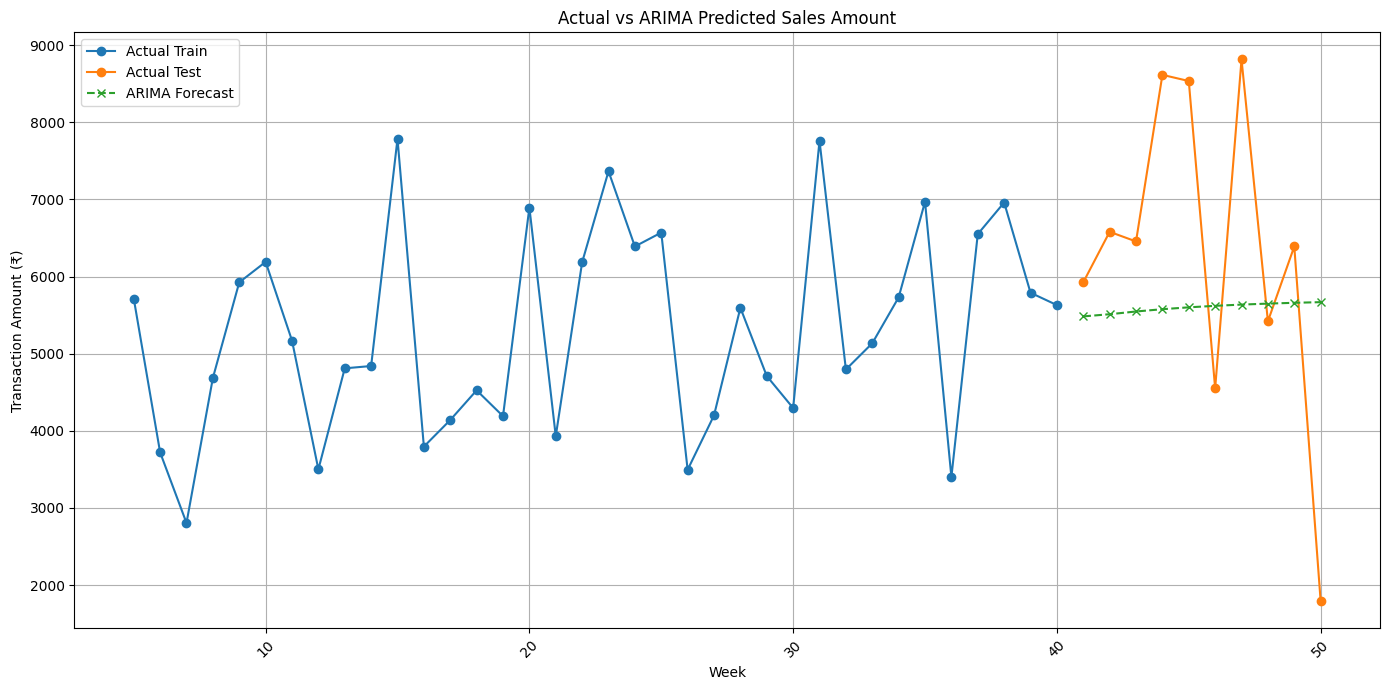

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
import warnings

warnings.filterwarnings("ignore")

# Load data
daily_sales = pd.read_csv("data/test/balaji_sales.csv")


df["Date"] = pd.to_datetime(df["date"], format='mixed', dayfirst=True)
df.sort_values(by="Date", inplace=True)
daily_sales = df.groupby("Date")[["quantity", "transaction_amount"]].sum().reset_index()
daily_sales["month"] = daily_sales["Date"].dt.month

daily_sales["week"] = 0 # initialize the week to be 0

daily_sales["week"] = (np.arange(len(daily_sales)) // 7) + 1

# Group by week
weekly_sales = daily_sales.groupby("week")[["quantity", "transaction_amount"]].sum().reset_index()

target = weekly_sales

# Create lag features (optional, ARIMA does not need them but keeping them in dataset if useful)
target["lag_1"] = target["transaction_amount"].shift(1)
target["rolling_2"] = target["transaction_amount"].shift(1).rolling(2).mean()
target["lag_4"] = target["transaction_amount"].shift(4)
target["rolling_4"] = target["transaction_amount"].shift(1).rolling(4).mean()

# Create trend target
target["trend"] = (target["transaction_amount"] > target["lag_1"]).astype(int)

# Drop NaN rows
target = target.dropna().reset_index(drop=True)

# Define target
y = target["transaction_amount"]

# Train/test split (no shuffle)
train_size = int(len(y) * 0.8)
y_train = y.iloc[:train_size]
y_test = y.iloc[train_size:]

dates_train = target["week"].iloc[:train_size]
dates_test = target["week"].iloc[train_size:]

# Fit ARIMA model (auto ARIMA or manual selection possible, here using (2,1,2) as common safe default)
model = ARIMA(y_train, order=(2, 1, 2))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=len(y_test))

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, forecast))
mae = mean_absolute_error(y_test, forecast)
medae = median_absolute_error(y_test, forecast)

print("ARIMA Results:")
print("RMSE:", rmse)
print("Percentage RMSE/Mean (Normalized Error):", rmse / target["transaction_amount"].mean() * 100, '%')
print("MAE (Mean Absolute Error):", mae)
print("Percentage MAE/Mean (Normalized Error):", mae / target["transaction_amount"].mean() * 100, '%')
print("MedAE (Median Absolute Error):", medae)
print("Percentage MedAE/Mean (Normalized Error):", medae / target["transaction_amount"].mean() * 100, '%')

# Plot
plt.figure(figsize=(14, 7))
plt.plot(dates_train, y_train, label="Actual Train", marker='o')
plt.plot(dates_test, y_test.values, label="Actual Test", marker='o')
plt.plot(dates_test, forecast.values, label="ARIMA Forecast", marker='x', linestyle="--")

plt.title("Actual vs ARIMA Predicted Sales Amount")
plt.xlabel("Week")
plt.ylabel("Transaction Amount (₹)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

13:06:25 - cmdstanpy - INFO - Chain [1] start processing
13:06:26 - cmdstanpy - INFO - Chain [1] done processing


Prophet Results:
RMSE: 508.27240971053766
Percentage RMSE/Mean (Normalized Error): 26.408078548343887 %
MAE (Mean Absolute Error): 435.3893461576607
Percentage MAE/Mean (Normalized Error): 22.621326345436717 %
MedAE (Median Absolute Error): 458.50046792486387
Percentage MedAE/Mean (Normalized Error): 23.822100393581923 %


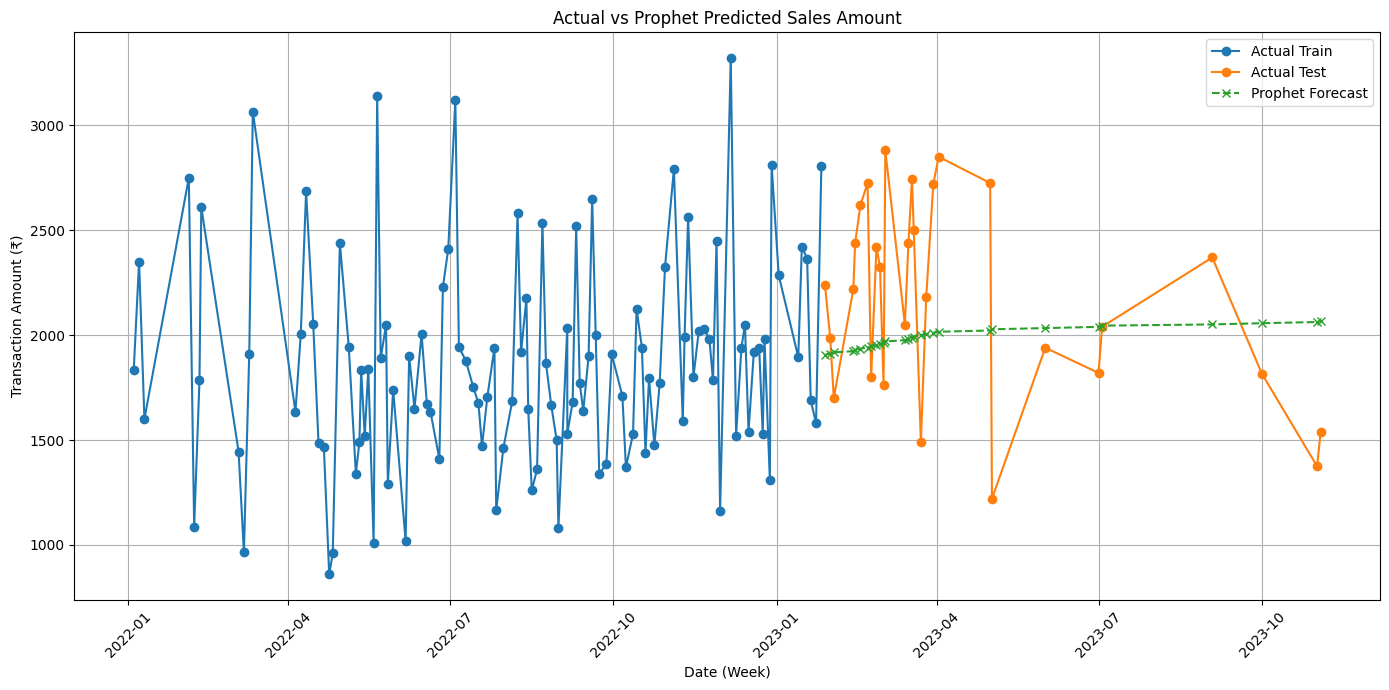

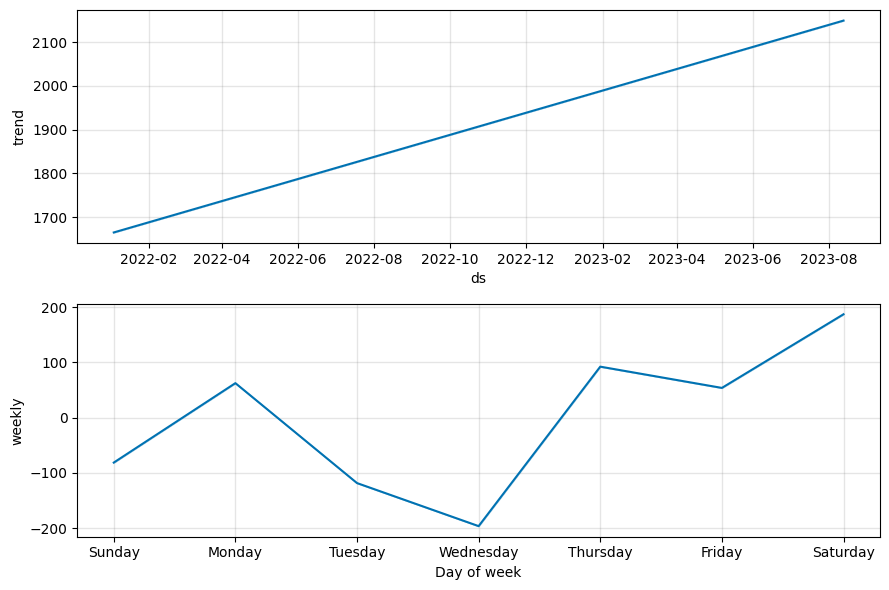

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from prophet import Prophet

# Load data
daily_sales = pd.read_csv("data/test/balaji_sales.csv")

# Convert date and sort
daily_sales["Date"] = pd.to_datetime(daily_sales["date"], format='mixed', dayfirst=True)
daily_sales.sort_values(by="Date", inplace=True)

# Assign week numbers
daily_sales["week"] = (np.arange(len(daily_sales)) // 7) + 1

# Group by week and sum sales
weekly_sales = daily_sales.groupby("week").agg({
    "Date": "first",  # take the first date for each week
    "transaction_amount": "sum"  # sum the sales amount
}).reset_index()

# Prepare data for Prophet
df_prophet = weekly_sales[["Date", "transaction_amount"]].rename(columns={"Date": "ds", "transaction_amount": "y"})

# Split train/test
train_size = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

# Initialize and fit Prophet
model = Prophet()
model.fit(train_df)

# Create future dataframe (same number of weeks as test)
future = model.make_future_dataframe(periods=len(test_df), freq='W')
forecast = model.predict(future)

# Extract forecasted values
forecast_y = forecast.iloc[-len(test_df):]["yhat"].values
actual_y = test_df["y"].values

# Evaluate
rmse = np.sqrt(mean_squared_error(actual_y, forecast_y))
mae = mean_absolute_error(actual_y, forecast_y)
medae = median_absolute_error(actual_y, forecast_y)

print("Prophet Results:")
print("RMSE:", rmse)
print("Percentage RMSE/Mean (Normalized Error):", rmse / df_prophet["y"].mean() * 100, '%')
print("MAE (Mean Absolute Error):", mae)
print("Percentage MAE/Mean (Normalized Error):", mae / df_prophet["y"].mean() * 100, '%')
print("MedAE (Median Absolute Error):", medae)
print("Percentage MedAE/Mean (Normalized Error):", medae / df_prophet["y"].mean() * 100, '%')

# Plot
plt.figure(figsize=(14, 7))
plt.plot(train_df["ds"], train_df["y"], label="Actual Train", marker='o')
plt.plot(test_df["ds"], test_df["y"], label="Actual Test", marker='o')
plt.plot(test_df["ds"], forecast_y, label="Prophet Forecast", marker='x', linestyle="--")

plt.title("Actual vs Prophet Predicted Sales Amount")
plt.xlabel("Date (Week)")
plt.ylabel("Transaction Amount (₹)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Plot Prophet's components (trend, seasonality, changepoints)
model.plot_components(forecast)
plt.show()

13:15:01 - cmdstanpy - INFO - Chain [1] start processing
13:15:01 - cmdstanpy - INFO - Chain [1] done processing


Hybrid Prophet + XGBboost Results:
RMSE: 584.9125670045247
Percentage RMSE/Mean (Normalized Error): 31.576552007507715 %
MAE (Mean Absolute Error): 464.4644615787958
MedAE (Median Absolute Error): 387.07312270326725
Percentage MedAE:  0      35.674942
1      21.684769
2      14.830388
3      26.787067
4      40.111204
         ...    
105    15.994757
106    16.366728
107    22.903735
108    24.498299
109    13.799398
Name: transaction_amount, Length: 110, dtype: float64


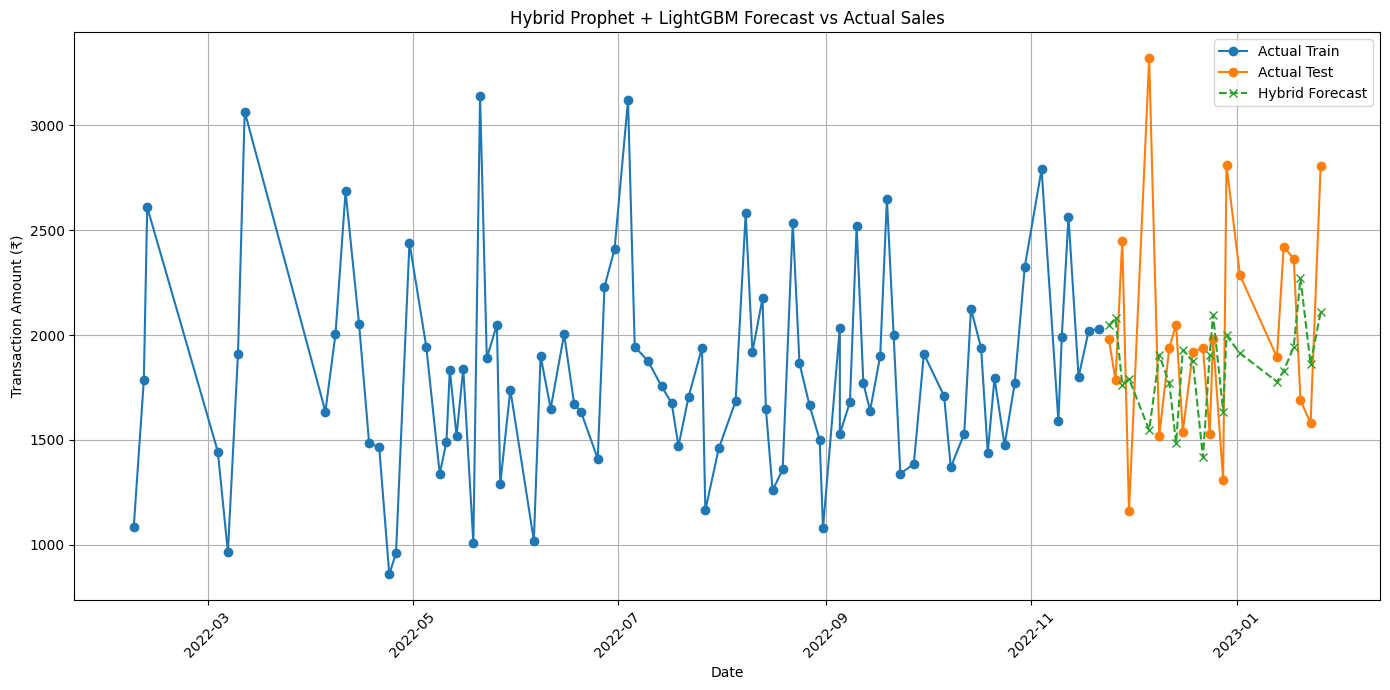

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error
from prophet import Prophet
from xgboost import XGBRegressor

# Load data
daily_sales = pd.read_csv("data/test/balaji_sales.csv")

# Convert date and sort
daily_sales["Date"] = pd.to_datetime(daily_sales["date"], format='mixed', dayfirst=True)
daily_sales.sort_values(by="Date", inplace=True)

# Assign week numbers
daily_sales["week"] = (np.arange(len(daily_sales)) // 7) + 1

# Group by week and sum sales
weekly_sales = daily_sales.groupby("week").agg({
    "Date": "first",
    "transaction_amount": "sum"
}).reset_index()

# Prepare Prophet data
df_prophet = weekly_sales[["Date", "transaction_amount"]].rename(columns={"Date": "ds", "transaction_amount": "y"})

# Train/test split
train_size = int(len(df_prophet) * 0.8)
train_df = df_prophet.iloc[:train_size]
test_df = df_prophet.iloc[train_size:]

# Train Prophet model
prophet = Prophet()
prophet.fit(train_df)

# Forecast with Prophet
future = prophet.make_future_dataframe(periods=len(test_df), freq='W')
forecast = prophet.predict(future)

# Merge Prophet forecast into weekly_sales
forecast_merged = forecast[["ds", "yhat"]].rename(columns={"ds": "Date", "yhat": "prophet_forecast"})
weekly_sales = pd.merge(weekly_sales, forecast_merged, on="Date", how="left")

# Calculate residuals
weekly_sales["residual"] = weekly_sales["transaction_amount"] - weekly_sales["prophet_forecast"]

# Create lag features
weekly_sales["lag_1"] = weekly_sales["residual"].shift(1)
weekly_sales["rolling_2"] = weekly_sales["residual"].shift(1).rolling(2).mean()
weekly_sales["lag_4"] = weekly_sales["residual"].shift(4)
weekly_sales["rolling_4"] = weekly_sales["residual"].shift(1).rolling(4).mean()

# Drop NaN rows
weekly_sales = weekly_sales.dropna().reset_index(drop=True)

# Prepare LightGBM data
X = weekly_sales[["lag_1", "rolling_2", "lag_4", "rolling_4"]]
y = weekly_sales["residual"]

# Train/test split
split_index = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
dates_train = weekly_sales["Date"].iloc[:split_index]
dates_test = weekly_sales["Date"].iloc[split_index:]

# Train LightGBM model
lgb_model =  XGBRegressor(n_estimators=500, max_depth=5, learning_rate=0.05, objective="reg:squarederror", random_state=42)
lgb_model.fit(X_train, y_train)

# Predict residuals
residual_preds = lgb_model.predict(X_test)

# Final predictions
prophet_forecast_test = weekly_sales["prophet_forecast"].iloc[split_index:].values
actual_sales = weekly_sales["transaction_amount"].iloc[split_index:].values

final_preds = prophet_forecast_test + residual_preds

# Evaluate
rmse = np.sqrt(mean_squared_error(actual_sales, final_preds))
mae = mean_absolute_error(actual_sales, final_preds)
medae = median_absolute_error(actual_sales, final_preds)

print("Hybrid Prophet + XGBboost Results:")
print("RMSE:", rmse)
print("Percentage RMSE/Mean (Normalized Error):", rmse / weekly_sales["transaction_amount"].mean() * 100, '%')
print("MAE (Mean Absolute Error):", mae)
print("MedAE (Median Absolute Error):", medae)
print("Percentage MedAE: ", medae/ weekly_sales["transaction_amount"] * 100)

# Plot
plt.figure(figsize=(14, 7))
plt.plot(dates_train, weekly_sales["transaction_amount"].iloc[:split_index], label="Actual Train", marker='o')
plt.plot(dates_test, actual_sales, label="Actual Test", marker='o')
plt.plot(dates_test, final_preds, label="Hybrid Forecast", marker='x', linestyle="--")

plt.title("Hybrid Prophet + LightGBM Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Transaction Amount (₹)")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()